# Assignment 2

## Instructions

- Your submission should be the `.ipynb` file with your name,
  like `FirstnameLastname.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
  training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
  Plagiarism in the code will result in failing. If you use code from the
  internet, cite it by adding the source of the code as a comment in the first line of the code cell.
- In real life clients can give unclear goals or requirements. So, if the instructions seem vague, use common sense to make reasonable assumptions.


# Task 1: [Where's Waldo?](https://www.wikihow.com/Find-Waldo) (35 points)

## Fingerprinting

Browser fingerprinting is a technique used to identify and track individuals based on unique characteristics of their web browser configuration. These characteristics can include the browser type, version, installed plugins, and screen resolution, among others. By combining these attributes, websites can create a digital fingerprint that can be used to track user behavior across multiple sites, even if they clear their cookies or use different devices. This has raised concerns about privacy and the potential for this technology to be used for targeted advertising, surveillance, and other purposes.

[Read more](<[Fingerprinting](https://datadome.co/learning-center/browser-fingerprinting-techniques/)>)

## What you need to do

For this task, you are required to build a fully connect feed-forward ANN model
for a classification problem.

For the given data, you need do proper data preprocessing, data analysis,
design the ANN model, then fine-tune your model architecture.

For evaluating your model, do $ 80/20 $ train test split.

### Learning Objectives

- Select and implement suitable data preprocessing techniques. 10%
- Identify the appropriate classification approach for a given problem. 20%
- Apply ANNs to solve a classification problem (basic training, validation, testing -- without fine tuning). 50%
- Fine-tune to determine the optimal model architecture. 20%

### Data

You will be working with the data in `Task_1.csv` for identifying waldo (the user with `user_id=0`)

The columns include:

- browser
- os
- locale
- user_id
- location
- sites
- time
- date

After training, evaluate you model by print [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
on your test set.

Then predicting each user in `task_1_verify.csv` whether it's Waldo or not. Your output should look like the following:

`row_idx: is_waldo`, notice if the user is waldo your output should be 1

```
0: 1
1: 0
2: 0
3: 1
4: 1
...
```


In [48]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import tqdm
from torch import sigmoid
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import warnings
import re
import numpy as np
import pandas as pd
import torch

In [49]:
df = pd.read_csv('task 1.csv')
print(df[df['user_id'] == 0].shape)
print(df[df['user_id'] != 0].shape)
print(df[df['user_id'] == 0].nunique())
df.head()


(400, 9)
(20001, 9)
index       400
browser       2
os            2
locale        1
user_id       1
location      3
sites       400
time        285
date        368
dtype: int64


,index,browser,os,locale,user_id,location,sites,time,date
0,8909,Firefox,Windows 10,zh-CN,46,China/Shanghai,"[{'site': '1.static.dpreview.com', 'length': 1...",14:14:00,2016-01-28
1,17679,Internet Explorer,Windows 8,ro-RO,21,Germany/Berlin,"[{'site': 'safebrowsing-cache.google.com', 'le...",05:23:00,2016-08-26
2,11803,Internet Explorer,MacOS,ur-PK,98,Australia/Sydney,"[{'site': 'www.ncbi.nlm.nih.gov', 'length': 10...",12:03:00,2016-03-13
3,356,Internet Explorer,Ubuntu,pl-PL,44,Japan/Tokyo,"[{'site': 'fr.hdscreen.me', 'length': 16}, {'s...",06:08:00,2017-01-19
4,10948,Internet Explorer,Windows 8,bg-BG,59,Japan/Tokyo,"[{'site': '193.164.196.50', 'length': 10}, {'s...",03:59:00,2017-05-13


In [50]:
print("Total amount of entries:", df.shape[0])
print("Total amount of columns:", df.shape[1])
print("Total amount of missing values:", df.isnull().isnull().sum().sum())
print("Total amount of unique values:")
df.nunique().sort_values(ascending=False)


Total amount of entries: 20401
Total amount of columns: 9
Total amount of missing values: 0
Total amount of unique values:


index       20401
sites       20388
time         1440
date          621
user_id       200
locale         25
location       21
os              6
browser         4
dtype: int64

In [51]:
print("Waldo's locale:", df[df['user_id'] == 0]['locale'].unique())
print("waldo's operating systems:", df[df['user_id'] == 0]['os'].unique())
print("Waldo's locations:", df[df['user_id'] == 0]['location'].unique())
print("Waldo's browsers", df[df['user_id'] == 0]['browser'].unique())


Waldo's locale: ['ru_RU']
waldo's operating systems: ['Ubuntu' 'Windows 10']
Waldo's locations: ['USA/Chicago' 'France/Paris' 'Canada/Toronto']
Waldo's browsers ['Firefox' 'Chrome']


In [52]:
warnings.filterwarnings('ignore')
setdom = set()
testdf = df['sites']
length_dict = {}
for j in range(len(testdf)):
    doms = re.findall(r'\.\w+\'', testdf[j])
    for i in range(len(doms)):
        if doms[i][0] == '.':
            doms[i] = doms[i][1:]
        if doms[i][-1] == '\'':
            doms[i] = doms[i][:-1]
        setdom.add(doms[i])
for i in setdom:
    lengths = re.findall(r': \d+', testdf[j])
    length_dict[i] = 0
    for j in range(len(lengths)):
        lengths[j] = lengths[j][2:]
        length_dict[i] += int(lengths[j])
setdom = set()
for i in length_dict:
    setdom.add(i)
domain_arr = (list(setdom))

for i in range(len(domain_arr)):
    df[domain_arr[i]] = 0
for i in range(len(df)):
    doms = re.findall(r'\.\w+\'', df['sites'][i])
    for j in range(len(doms)):
        if doms[j][0] == '.':
            doms[j] = doms[j][1:]
        if doms[j][-1] == '\'':
            doms[j] = doms[j][:-1]
    for j in range(len(doms)):
        df[doms[j]][i] = 1
df.head()


,index,browser,os,locale,user_id,location,sites,time,date,14,...,cd,nl,au,cm,gd,tn,museum,70,mu,info
0,8909,Firefox,Windows 10,zh-CN,46,China/Shanghai,"[{'site': '1.static.dpreview.com', 'length': 1...",14:14:00,2016-01-28,0,...,0,0,0,0,0,0,0,0,0,0
1,17679,Internet Explorer,Windows 8,ro-RO,21,Germany/Berlin,"[{'site': 'safebrowsing-cache.google.com', 'le...",05:23:00,2016-08-26,0,...,0,0,0,0,0,0,0,0,0,0
2,11803,Internet Explorer,MacOS,ur-PK,98,Australia/Sydney,"[{'site': 'www.ncbi.nlm.nih.gov', 'length': 10...",12:03:00,2016-03-13,0,...,0,0,0,0,0,0,0,0,0,0
3,356,Internet Explorer,Ubuntu,pl-PL,44,Japan/Tokyo,"[{'site': 'fr.hdscreen.me', 'length': 16}, {'s...",06:08:00,2017-01-19,0,...,0,0,0,0,0,0,0,0,0,0
4,10948,Internet Explorer,Windows 8,bg-BG,59,Japan/Tokyo,"[{'site': '193.164.196.50', 'length': 10}, {'s...",03:59:00,2017-05-13,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df.drop('index', axis=1, inplace=True)
df.drop('sites', axis=1, inplace=True)
df.drop('date', axis=1, inplace=True)
df.drop('time', axis=1, inplace=True)
df[df['user_id'] == 0]


,browser,os,locale,user_id,location,14,me,ly,it,ro,...,cd,nl,au,cm,gd,tn,museum,70,mu,info
31,Firefox,Ubuntu,ru_RU,0,USA/Chicago,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,Firefox,Ubuntu,ru_RU,0,USA/Chicago,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212,Firefox,Ubuntu,ru_RU,0,USA/Chicago,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
253,Chrome,Ubuntu,ru_RU,0,France/Paris,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287,Chrome,Ubuntu,ru_RU,0,France/Paris,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19982,Chrome,Ubuntu,ru_RU,0,Canada/Toronto,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20089,Firefox,Ubuntu,ru_RU,0,USA/Chicago,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20154,Chrome,Windows 10,ru_RU,0,Canada/Toronto,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20175,Chrome,Ubuntu,ru_RU,0,USA/Chicago,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [54]:
ohe = OneHotEncoder()
ohe.fit(df[['browser', 'os', 'locale', 'location']])
ohe.categories_
df_ohe = ohe.transform(df[['browser', 'os', 'locale', 'location']]).toarray()
df_ohe = pd.DataFrame(df_ohe, columns=ohe.get_feature_names_out(
    ['browser', 'os', 'locale', 'location']))
df = pd.concat([df, df_ohe], axis=1)
df.drop(['browser', 'os', 'locale', 'location'], axis=1, inplace=True)
df.head()


,user_id,14,me,ly,it,ro,30,lu,ar,mx,...,location_Netherlands/Amsterdam,location_New Zealand/Auckland,location_Russia/Moscow,location_Singapore/Singapore,location_Spain/Madrid,location_UK/London,location_USA/Chicago,location_USA/Miami,location_USA/New York,location_USA/San Francisco
0,46,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,98,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# we will be predicting is_waldo column so we will be using it as a target
df['is_waldo'] = df['user_id'].apply(lambda x: 1 if x == 0 else 0)
target = df['is_waldo'].values
df.drop('is_waldo', axis=1, inplace=True)
df.drop('user_id', axis=1, inplace=True)
data = df.values
df.head()


,14,me,ly,it,ro,30,lu,ar,mx,by,...,location_Netherlands/Amsterdam,location_New Zealand/Auckland,location_Russia/Moscow,location_Singapore/Singapore,location_Spain/Madrid,location_UK/London,location_USA/Chicago,location_USA/Miami,location_USA/New York,location_USA/San Francisco
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
class DataFrameWaldo(torch.utils.data.Dataset):
    def __init__(self, data, target):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx, :], self.target[idx]


In [57]:
data = data.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, stratify=target)
train_dataset = DataFrameWaldo(X_train, y_train)
test_dataset = DataFrameWaldo(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)
data1, target1 = next(iter(train_loader))
print(data1.shape)
print(target1.shape)


torch.Size([32, 183])
torch.Size([32])


In [58]:
class Net(nn.Module):
    def __init__(self, layers_count, neurons_count):
        super(Net, self).__init__()
        self.layers_count = layers_count
        self.neurons_count = neurons_count
        self.fc1 = nn.Linear(183, neurons_count)
        for i in range(layers_count):
            setattr(self, f"fc{i + 2}",
                    nn.Linear(neurons_count, neurons_count))
        setattr(self, f"fc{layers_count + 2}", nn.Linear(neurons_count, 2))

    def forward(self, x):
        x = self.fc1(x)
        for i in range(self.layers_count):
            x = getattr(self, f"fc{i + 2}")(x)
            x = sigmoid(x)
        x = getattr(self, f"fc{self.layers_count + 2}")(x)
        x = sigmoid(x)
        return x

    def fit(self, train_loader, test_loader, epochs=10):
        self.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        for _ in range(epochs):
            for _, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = self(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            test(self, "cpu", test_loader, criterion)

    def score(self, test_loader):
        with torch.no_grad():
            for data, target in test_loader:
                output = self(data)
                _, predicted = torch.max(output.data, 1)
        f1 = f1_score(target, predicted, average='macro')
        print(f"F1 score: {f1}")
        return f1


In [59]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    bar = tqdm.tqdm(train_loader)
    iteration = 0
    overall_loss = 0
    for data, target in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        iteration += 1
        overall_loss += loss.item()
        predicted = torch.max(output.data, 1)[1]
        f1 = f1_score(target, predicted, average='macro')
        bar.set_postfix({"Loss": format(overall_loss/iteration, '.6f')})
    print(
        f"Epoch {epoch} finished. Loss: {overall_loss/iteration}. F1 score: {f1}")


In [60]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            y_pred.append(pred.detach().numpy())
            y_true.append(target.detach().numpy())
    test_loss /= len(test_loader.dataset)
    return y_true, y_pred


In [61]:
hidden_layers = [1, 2, 3, 4]
neurons = [10, 20, 30, 40, 50]
best_f1 = -1
best_layers_count = 0
best_neurons_count = 0
best_model = None
device = "cpu"
for layers_count in hidden_layers:
    for neurons_count in neurons:
        model = Net(layers_count, neurons_count).to(device)
        model.fit(train_loader, test_loader, epochs=10)
        f1 = model.score(test_loader)
        if f1 > best_f1:
            best_f1 = f1
            best_layers_count = layers_count
            best_neurons_count = neurons_count
            best_model = model
print(f"Best f1: {best_f1:.4f} with {best_layers_count} hidden layers and {best_neurons_count} neurons")


F1 score: 1.0
F1 score: 1.0
F1 score: 1.0
F1 score: 1.0
F1 score: 1.0
F1 score: 1.0
F1 score: 0.9411764705882353
F1 score: 1.0
F1 score: 1.0
F1 score: 0.49056603773584906
F1 score: 0.4968944099378882
F1 score: 0.4968944099378882
F1 score: 0.4968944099378882
F1 score: 0.49375
F1 score: 0.4968944099378882
F1 score: 1.0
F1 score: 0.49375
F1 score: 0.49375
F1 score: 0.49056603773584906
F1 score: 0.4968944099378882
Best f1: 1.0000 with 1 hidden layers and 10 neurons


In [62]:
device = torch.device("cpu")
model = Net(best_layers_count, best_neurons_count).to(device)
print(f"Model architecture:\n {model}")
print("Device:", device)


Model architecture:
 Net(
  (fc1): Linear(in_features=183, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)
Device: cpu


In [64]:
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs+1):
    train(model, device, train_loader, criterion, optimizer, epoch)
    y_true, y_pred = test(model, device, test_loader, criterion)
print(classification_report(np.concatenate(y_true), np.concatenate(y_pred)))


100%|██████████| 510/510 [00:03<00:00, 143.99it/s, Loss=0.313840]


Epoch 0 finished. Loss: 0.3138403945693783. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 143.56it/s, Loss=0.313798]


Epoch 1 finished. Loss: 0.31379791720240724. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 150.17it/s, Loss=0.313833]


Epoch 2 finished. Loss: 0.31383321530678693. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 146.25it/s, Loss=0.313725]


Epoch 3 finished. Loss: 0.3137253408922869. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 149.05it/s, Loss=0.313733]


Epoch 4 finished. Loss: 0.3137327423282698. F1 score: 0.825136612021858


100%|██████████| 510/510 [00:03<00:00, 151.49it/s, Loss=0.313676]


Epoch 5 finished. Loss: 0.31367597761107424. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 146.83it/s, Loss=0.313662]


Epoch 6 finished. Loss: 0.3136615942506229. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 149.30it/s, Loss=0.313661]


Epoch 7 finished. Loss: 0.313660902427692. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 149.19it/s, Loss=0.313637]


Epoch 8 finished. Loss: 0.31363696970191657. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 148.16it/s, Loss=0.313630]


Epoch 9 finished. Loss: 0.3136296195726769. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 150.73it/s, Loss=0.313604]


Epoch 10 finished. Loss: 0.3136036694049835. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 145.17it/s, Loss=0.313550]


Epoch 11 finished. Loss: 0.313549735733107. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 150.21it/s, Loss=0.313703]


Epoch 12 finished. Loss: 0.3137034034612132. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 149.66it/s, Loss=0.313577]


Epoch 13 finished. Loss: 0.31357688237639036. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 150.46it/s, Loss=0.313639]


Epoch 14 finished. Loss: 0.31363864792328255. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 148.31it/s, Loss=0.313590]


Epoch 15 finished. Loss: 0.3135904925126655. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 150.10it/s, Loss=0.313567]


Epoch 16 finished. Loss: 0.31356698601853616. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 147.83it/s, Loss=0.313631]


Epoch 17 finished. Loss: 0.31363121142574385. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 148.18it/s, Loss=0.313606]


Epoch 18 finished. Loss: 0.31360613843973945. F1 score: 0.825136612021858


100%|██████████| 510/510 [00:03<00:00, 144.77it/s, Loss=0.313654]


Epoch 19 finished. Loss: 0.3136543770046795. F1 score: 1.0


100%|██████████| 510/510 [00:03<00:00, 150.99it/s, Loss=0.313554]


Epoch 20 finished. Loss: 0.3135541494570526. F1 score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4001
           1       0.94      0.99      0.96        80

    accuracy                           1.00      4081
   macro avg       0.97      0.99      0.98      4081
weighted avg       1.00      1.00      1.00      4081



In [65]:
df_verify = pd.read_csv('task_1_verify.csv')
df_verify.head()


,browser,os,locale,location,sites,time,date
0,Firefox,Windows 7,xh-ZA,USA/New York,"[{'site': 'rr.office.microsoft.com', 'length':...",11:30:00,2016-10-05
1,Chrome,Windows 10,pl-PL,Japan/Tokyo,"[{'site': 'maps.google.com', 'length': 14}, {'...",14:35:00,2016-05-06
2,Firefox,Debian,vi-VN,France/Paris,"[{'site': 'cbk1.googleapis.com', 'length': 178...",14:31:00,2016-03-27
3,Firefox,Debian,en-US,Canada/Vancouver,"[{'site': 'annotathon.org', 'length': 72}, {'s...",10:55:00,2016-12-31
4,Firefox,Debian,en-CA,Australia/Sydney,"[{'site': 'apis.google.com', 'length': 75}, {'...",03:30:00,2017-01-19


In [66]:
df_verify.drop('date', axis=1, inplace=True)
df_verify.drop('time', axis=1, inplace=True)


In [67]:
warnings.filterwarnings('ignore')
for i in range(len(domain_arr)):
    df_verify[domain_arr[i]] = 0
for i in range(len(df_verify)):
    doms = re.findall(r'\.\w+\'', df_verify['sites'][i])
    for j in range(len(doms)):
        if doms[j][0] == '.':
            doms[j] = doms[j][1:]
        if doms[j][-1] == '\'':
            doms[j] = doms[j][:-1]
    for j in range(len(doms)):
        df_verify[doms[j]][i] = 1
df_verify.drop('sites', axis=1, inplace=True)
df_verify.head()


,browser,os,locale,location,14,me,ly,it,ro,30,...,cd,nl,au,cm,gd,tn,museum,70,mu,info
0,Firefox,Windows 7,xh-ZA,USA/New York,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Chrome,Windows 10,pl-PL,Japan/Tokyo,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Firefox,Debian,vi-VN,France/Paris,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Firefox,Debian,en-US,Canada/Vancouver,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Firefox,Debian,en-CA,Australia/Sydney,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
df = pd.read_csv('task 1.csv')
df.drop('index', axis=1, inplace=True)
df.drop('sites', axis=1, inplace=True)
df.drop('date', axis=1, inplace=True)
df.drop('time', axis=1, inplace=True)
df.drop('user_id', axis=1, inplace=True)
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df[['browser', 'os', 'locale', 'location']])
ohe.categories_
df_ohe = ohe.transform(df[['browser', 'os', 'locale', 'location']])
df_ohe = pd.DataFrame(df_ohe, columns=ohe.get_feature_names_out(
    ['browser', 'os', 'locale', 'location']))
df = pd.concat([df, df_ohe], axis=1)
df.drop(['browser', 'os', 'locale', 'location'], axis=1, inplace=True)
df_ohe = ohe.transform(df_verify[['browser', 'os', 'locale', 'location']])
df_ohe = pd.DataFrame(df_ohe, columns=ohe.get_feature_names_out(
    ['browser', 'os', 'locale', 'location']))
df_verify = pd.concat([df_verify, df_ohe], axis=1)
df_verify.drop(['browser', 'os', 'locale', 'location'], axis=1, inplace=True)
df_verify.head()


,14,me,ly,it,ro,30,lu,ar,mx,by,...,location_Netherlands/Amsterdam,location_New Zealand/Auckland,location_Russia/Moscow,location_Singapore/Singapore,location_Spain/Madrid,location_UK/London,location_USA/Chicago,location_USA/Miami,location_USA/New York,location_USA/San Francisco
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
class VerifyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx, :]


data_verify = VerifyDataset(df_verify.values)


In [70]:
def evaluate(model, device, dataset):
    i = 0
    model.eval()
    with torch.no_grad():
        for data in dataset:
            data = data.to(device)
            output = model(data)
            print(f"{i}: {np.argmax(output.detach().numpy())}")
            i += 1


evaluate(model, device, data_verify)


0: 0
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
10: 0
11: 0
12: 0
13: 0
14: 0
15: 0
16: 0
17: 0
18: 0
19: 0
20: 0
21: 0
22: 0
23: 0
24: 0
25: 0
26: 0
27: 0
28: 0
29: 0
30: 0
31: 1
32: 1
33: 1
34: 1
35: 1


### Questions

1. Did you find any usefull insights from your data analysis? 
   - _Answer_ The dataset has 400 Waldo users and 20001 non-Waldo users. The dataset is
   imbalanced. Moreover, Waldo uses ony 1 locale (ru_RU), 2 Operating Systems (Ubuntu and Windows 10), 3 locations (USA/Chicago, France/Paris, Canada/Toronto) and 2 browsers (Chrome and Firefox).
2. What preprocessing techniques did you use? Why?
   - _Answer_ I used manual encoding for first level domains of visited sites as there will be too many columns if I used second level domains.
   Also I used one-hot encoding for the rest of the categorical features.
3. Describe the fine-tuning process and how you reached your model architecture.
   - _Answer_At first I used Very basic Net with only one Linear layer, then I added varying amount of hidden layers with controllable amount of neurons. After that I wrote a manual fridsearch over amount of hidden layers and their size. Surprisingly, the following structure was deemed most efficient several times:
   Model architecture:
 Net(
  (fc1): Linear(in_features=183, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)
4. Which metric did you try to optemize for this task? Why?
   - _Answer_ I used F1 score as it is a good metric for imbalanced datasets.


# Task 2: Fingerprint Recognition (50 points)

Fingerprint recognition is a highly accurate and reliable biometric technology that is used for identification and authentication purposes. By analyzing the unique patterns and ridges on an individual's fingerprint, it is possible to verify their identity with a high degree of confidence. This technology is widely used in law enforcement, border control, and access control systems, as well as in mobile devices and payment systems, to ensure secure and reliable identification and authentication.

In this task you will be doing a simplified version of Fingerprint ID, which is just identifying which finger is used in the image

## What you need to do

For this task, you will be doing image classification:

- Build a CNN model for image classification.
- Estimate the speed of inference of your model

For the given data, you need to do proper data preprocessing, augmentation, and data loaders.

Then fine-tune your model architecture to achieve the highest accuracy.

### Learning Objectives

- Select and implement suitable data preprocessing techniques. 10%
- Use literature (any paper on the use of CNN for fingerprinting and cite it) to choose an architecture. 10%
- Apply CNNs to solve an image classification problem (basic training, validation, testing -- without fine tuning). 40%
- Fine-tune your model to improve performance. 20%
- Use of data augmentation to improve model’s performance. 20%
- Explore beyond data augmentation find techniques to improve model’s performance and use them. 15%(bonus)

### Data

[Download link](https://drive.google.com/file/d/1iMIdYKSmCjVL5p-yzy-oInLMtTVt-1_j/view?usp=share_link)

You will be working with the data in `task_2.zip` for identifying. The name of each image consists of 2 parts like
`idx_label.BMB`

Where the idx is the index of the image and the label is the target class.

Each label corresponds to a finger:

```
0-> left_thumb
1-> left_index
2-> left_middle
3-> left_ring
4-> left_little
5-> right_thumb
6-> right_index
7-> right_middle
8-> right_ring
9-> right_little
```


In [2]:
from time import time
from torch.autograd import Variable
import torch.optim as optim
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import cv2
import urllib.request
import zipfile
import os
from torchsummary import summary


In [24]:
if not os.path.exists('train') or not os.path.exists('test'):
    url = 'https://drive.google.com/u/0/uc?id=1iMIdYKSmCjVL5p-yzy-oInLMtTVt-1_j&export=download&confirm=t&uuid=0bc79cc8-874d-46d9-92e2-3ef5013c1c48&at=ANzk5s4N4X4s1_IjTjgQdk8_KxYd:1680341775045'
    file_name = 'task 2.zip'
    urllib.request.urlretrieve(url, file_name)
    zip_ref = zipfile.ZipFile(file_name, 'r')
    zip_ref.extractall()
    zip_ref.close()
    os.remove('task 2.zip')


In [25]:
if not os.path.exists('train'):
    zip_ref = zipfile.ZipFile('train.zip', 'r')
    zip_ref.extractall()
    zip_ref.close()

if not os.path.exists('test'):
    zip_ref = zipfile.ZipFile('test.zip', 'r')
    zip_ref.extractall()
    zip_ref.close()
    os.mkdir('test')

    for filename in os.listdir('content/test'):
        os.rename('content/test/'+filename, 'test/'+filename)
    os.rmdir('content/test')
    os.rmdir('content')


if os.path.exists('train.zip'):
    os.remove('train.zip')
if os.path.exists('test.zip'):
    os.remove('test.zip')

for filename in os.listdir('test'):
    if not filename.endswith('.bmp'):
        os.rename('test/'+filename, 'test/'+filename+'.bmp')


There is 2 different sizes of images in the dataset
Name: 10000_2.bmp, Folder: train, Shape: (103, 96, 3)


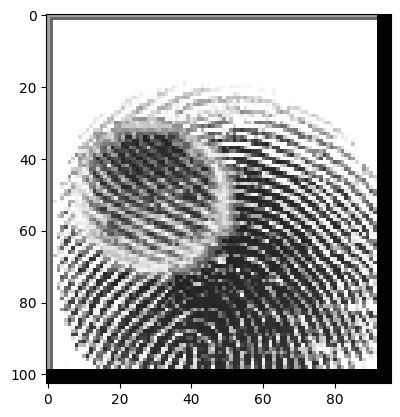

Name: 10168_0.bmp, Folder: train, Shape: (298, 241, 3)


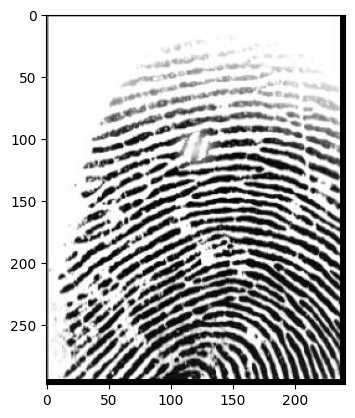

In [26]:
setsizes = ()

files = [f for f in os.listdir(
    'train') if os.path.isfile(os.path.join('train', f))]
for file in files:
    x = int(os.path.getsize('train/'+file))
    if x not in setsizes:
        setsizes += (x, file, 'train')

files = [f for f in os.listdir(
    'test') if os.path.isfile(os.path.join('test', f))]
for file in files:
    x = int(os.path.getsize('test/'+file))
    if x not in setsizes:
        setsizes += (x, file, 'test')
print(
    f'There is {int(len(setsizes)/3)} different sizes of images in the dataset')
for i in range(0, len(setsizes), 3):
    img = cv2.imread(setsizes[i+2]+'/'+setsizes[i+1])
    print(
        f'Name: {setsizes[i+1]}, Folder: {setsizes[i+2]}, Shape: {img.shape}')
    plt.imshow(img)
    plt.show()


In [27]:
def remove_right(img):
    for i in range(img.shape[1]-1, 0, -1):
        if len(set(img[:, i, :].flatten())) > 1:
            return img[:, :i+1, :]
    return img


def remove_left(img):
    for i in range(img.shape[1]):
        if len(set(img[:, i, :].flatten())) > 1:
            return img[:, i:, :]
    return img


def remove_top(img):
    for i in range(img.shape[0]):
        if len(set(img[i, :, :].flatten())) > 1:
            return img[i:, :, :]
    return img


def remove_bottom(img):
    for i in range(img.shape[0]-1, 0, -1):
        if len(set(img[i, :, :].flatten())) > 1:
            return img[:i+1, :, :]
    return img


def remove_all(img):
    while True:
        img_initial = img
        img = remove_right(img)
        img = remove_left(img)
        img = remove_top(img)
        img = remove_bottom(img)
        if np.array_equal(img, img_initial):
            break
    return img


In [28]:
def preprocess_image(img_path):
    path = img_path.split('.')[0]
    if img_path.count('/') != 0:
        path = path.split('/')[1]
    target = int(path.split('_')[1])
    img = cv2.imread(img_path)
    img = remove_all(img)
    img = cv2.resize(img, (64, 64))
    return img, target


In [29]:
df_train = pd.DataFrame(columns=['image', 'target'])
for i, img_path in tqdm(enumerate(os.listdir('train'))):
    image, target = preprocess_image('train/'+img_path)
    image = ToTensor()(image)
    df_train.loc[i] = [image, target]

df_test = pd.DataFrame(columns=['image', 'target'])
for i, img_path in tqdm(enumerate(os.listdir('test'))):
    image, target = preprocess_image('test/'+img_path)
    image = ToTensor()(image)
    df_test.loc[i] = [image, target]


19413it [01:33, 208.04it/s]
14272it [01:09, 204.75it/s]


In [30]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


class ImageDataSet(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.df.loc[idx, 'image']
        target = self.df.loc[idx, 'target']
        if self.transform:
            img = self.transform(img)
        return img, target


train_dataset = ImageDataSet(df_train,  transform=train_transforms)
test_dataset = ImageDataSet(df_test, transform=test_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [31]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, 3, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.out = nn.Linear(9248, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = x.flatten(start_dim=1)
        output = self.out(x)
        return output


class MobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bottleneck1 = self._make_bottleneck(32, 64, 1, 1)
        self.bottleneck2 = self._make_bottleneck(64, 128, 2, 2)
        self.bottleneck3 = self._make_bottleneck(128, 128, 1, 2)
        self.bottleneck4 = self._make_bottleneck(128, 256, 2, 2)
        self.bottleneck5 = self._make_bottleneck(256, 256, 1, 2)
        self.bottleneck6 = self._make_bottleneck(256, 512, 2, 2)
        self.bottleneck7 = self._make_bottleneck(512, 512, 1, 2)
        self.bottleneck8 = self._make_bottleneck(512, 512, 1, 2)
        self.bottleneck9 = self._make_bottleneck(512, 512, 1, 2)
        self.bottleneck10 = self._make_bottleneck(512, 512, 1, 2)
        self.bottleneck11 = self._make_bottleneck(512, 512, 1, 2)
        self.bottleneck12 = self._make_bottleneck(512, 1024, 2, 2)
        self.bottleneck13 = self._make_bottleneck(1024, 1024, 1, 2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def _make_bottleneck(self, in_channels, out_channels, stride, t):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, kernel_size=1),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels * t, in_channels * t, kernel_size=3,
                      stride=stride, padding=1, groups=in_channels * t),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels * t, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bottleneck1(x)
        x = self.bottleneck2(x)
        x = self.bottleneck3(x)
        x = self.bottleneck4(x)
        x = self.bottleneck5(x)
        x = self.bottleneck6(x)
        x = self.bottleneck7(x)
        x = self.bottleneck8(x)
        x = self.bottleneck9(x)
        x = self.bottleneck10(x)
        x = self.bottleneck11(x)
        x = self.bottleneck12(x)
        x = self.bottleneck13(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        return self.fc(x)


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(3136, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output


class VGG(nn.Module):
    def __init__(self,  num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(147, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


class TinyVGG(nn.Module):
    def __init__(self, num_classes=10, init_weights=True):
        super(TinyVGG, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(147, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


class squeezeNet(nn.Module):
    def __init__(self, num_classes=10, init_weights=True):
        super(squeezeNet, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(147, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [3]:
# https://arxiv.org/pdf/1512.03385.pdf
# https://www.researchgate.net/publication/311609041_Deep_Residual_Learning_for_Image_Recognition
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ResNet(ResBlock, [2, 2, 2, 2])
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()
print(model)

cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [34]:
def train(model, device, train_loader, criterion, optimizer, epoch, show_output=True):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    iteration = 0
    if show_output:
        bar = tqdm(train_loader)
    else:
        bar = train_loader
    for data, target in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        iteration += 1
        if show_output:
            bar.set_postfix({"Loss": format(epoch_loss/iteration, '.6f')})
    f1 = f1_score(target.cpu(), pred.cpu(), average='macro')
    if show_output:
        print(f'\rTrain Epoch: {epoch}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss, f1


def test(model, show_output=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data), Variable(target)
            target = target.long()
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.to(device)
            test_loss += F.cross_entropy(output,
                                         target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    f1 = f1_score(target.data.view_as(pred).cpu(), pred.cpu(), average='macro')
    if show_output:
        print(
            f'Test set: Loss: {test_loss:.4f}, F1: {f1:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')
    return test_loss, f1


In [35]:
nets = [VGG(), CNN(), TinyVGG(), MobileNet(), LeNet(), squeezeNet()]
arr = []
for net in nets:
    max_f1 = 0
    net = net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, 10):
        train(net, device, train_loader, criterion,
              optimizer, epoch, show_output=False)
        _, f1 = test(net, show_output=False)
        max_f1 = max(max_f1, f1.item())
    arr.append(max_f1)



In [36]:
model = ResNet(block=ResBlock, layers=[2, 2, 2, 2])
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


In [37]:
for epoch in range(1, 21):
    train(model, device, train_loader, criterion,
          optimizer, epoch, show_output=True)
    _, f1 = test(model, show_output=True)
    max_f1 = max(max_f1, f1.item())
arr.append(max_f1)


100%|██████████| 304/304 [00:24<00:00, 12.16it/s, Loss=1.321398]


Train Epoch: 1, elapsed time:25.00s
Test set: Loss: 1.1916, F1: 0.5039, Accuracy: 8162/14272 (57%)


100%|██████████| 304/304 [00:24<00:00, 12.27it/s, Loss=0.814170]


Train Epoch: 2, elapsed time:24.78s
Test set: Loss: 1.3097, F1: 0.4981, Accuracy: 7880/14272 (55%)


100%|██████████| 304/304 [00:26<00:00, 11.40it/s, Loss=0.582614]


Train Epoch: 3, elapsed time:26.66s
Test set: Loss: 0.9347, F1: 0.6172, Accuracy: 9587/14272 (67%)


100%|██████████| 304/304 [00:25<00:00, 11.81it/s, Loss=0.404482]


Train Epoch: 4, elapsed time:25.75s
Test set: Loss: 0.9710, F1: 0.6622, Accuracy: 9621/14272 (67%)


100%|██████████| 304/304 [00:26<00:00, 11.42it/s, Loss=0.274427]


Train Epoch: 5, elapsed time:26.63s
Test set: Loss: 0.9978, F1: 0.6259, Accuracy: 9669/14272 (68%)


100%|██████████| 304/304 [00:26<00:00, 11.32it/s, Loss=0.182578]


Train Epoch: 6, elapsed time:26.86s
Test set: Loss: 1.3176, F1: 0.6965, Accuracy: 9339/14272 (65%)


100%|██████████| 304/304 [00:26<00:00, 11.54it/s, Loss=0.135516]


Train Epoch: 7, elapsed time:26.35s
Test set: Loss: 0.4787, F1: 0.7344, Accuracy: 12039/14272 (84%)


100%|██████████| 304/304 [00:27<00:00, 11.21it/s, Loss=0.083600]


Train Epoch: 8, elapsed time:27.13s
Test set: Loss: 0.6465, F1: 0.7035, Accuracy: 11397/14272 (80%)


100%|██████████| 304/304 [00:27<00:00, 11.10it/s, Loss=0.082020]


Train Epoch: 9, elapsed time:27.40s
Test set: Loss: 0.5479, F1: 0.8066, Accuracy: 11848/14272 (83%)


100%|██████████| 304/304 [00:27<00:00, 11.19it/s, Loss=0.061787]


Train Epoch: 10, elapsed time:27.18s
Test set: Loss: 0.4568, F1: 0.7589, Accuracy: 12234/14272 (86%)


100%|██████████| 304/304 [00:28<00:00, 10.84it/s, Loss=0.046288]


Train Epoch: 11, elapsed time:28.06s
Test set: Loss: 0.7214, F1: 0.7197, Accuracy: 11363/14272 (80%)


100%|██████████| 304/304 [00:29<00:00, 10.44it/s, Loss=0.053269]


Train Epoch: 12, elapsed time:29.12s
Test set: Loss: 0.4553, F1: 0.7948, Accuracy: 12278/14272 (86%)


100%|██████████| 304/304 [00:28<00:00, 10.64it/s, Loss=0.039659]


Train Epoch: 13, elapsed time:28.58s
Test set: Loss: 0.3740, F1: 0.7304, Accuracy: 12573/14272 (88%)


100%|██████████| 304/304 [00:28<00:00, 10.50it/s, Loss=0.027255]


Train Epoch: 14, elapsed time:28.95s
Test set: Loss: 0.3713, F1: 0.8570, Accuracy: 12665/14272 (89%)


100%|██████████| 304/304 [00:28<00:00, 10.61it/s, Loss=0.018089]


Train Epoch: 15, elapsed time:28.66s
Test set: Loss: 0.3214, F1: 0.9222, Accuracy: 12865/14272 (90%)


100%|██████████| 304/304 [00:28<00:00, 10.59it/s, Loss=0.019568]


Train Epoch: 16, elapsed time:28.70s
Test set: Loss: 0.5764, F1: 0.7745, Accuracy: 11926/14272 (84%)


100%|██████████| 304/304 [00:28<00:00, 10.61it/s, Loss=0.013302]


Train Epoch: 17, elapsed time:28.66s
Test set: Loss: 0.3269, F1: 0.8042, Accuracy: 12848/14272 (90%)


100%|██████████| 304/304 [00:28<00:00, 10.66it/s, Loss=0.012990]


Train Epoch: 18, elapsed time:28.52s
Test set: Loss: 0.3233, F1: 0.9266, Accuracy: 12914/14272 (90%)


100%|██████████| 304/304 [00:28<00:00, 10.62it/s, Loss=0.015226]


Train Epoch: 19, elapsed time:28.64s
Test set: Loss: 0.4053, F1: 0.8534, Accuracy: 12656/14272 (89%)


100%|██████████| 304/304 [00:29<00:00, 10.16it/s, Loss=0.010939]


Train Epoch: 20, elapsed time:29.91s
Test set: Loss: 0.3563, F1: 0.9148, Accuracy: 12781/14272 (90%)


In [38]:
print(f'VGG: {arr[0]}, CNN: {arr[1]}, TinyVGG: {arr[2]}, MobileNet: {arr[3]}, LeNet: {arr[4]}, SqueezeNet: {arr[5]}, ResNet: {arr[6]}')


VGG: 0.3868260611227363, CNN: 0.6930668677727502, TinyVGG: 0.35554945054945053, MobileNet: 0.7953632478632479, LeNet: 0.031578947368421054, SqueezeNet: 0.39732128896215585, ResNet: 0.9265671420083186


### Questions

1. What preprocessing techniques did you use? Why?
   - _Answer_ I wrote a function remove_all() which removes all borders from all images, also I checked if all files had .bmp extension and added where it was missing. I have also fund out that there are 2 sizes of original images: 103 by 96 and 298 by 241.
2. What data augmentation techniques did you use?
   - _Answer_ I tried different combinations of flips, affines and crops but ultimately they all made the model perform worse. So I ended up keeping only RandomRotation.
3. Describe the fine-tuning process and how you reached your final CNN model.
   - _Answer_ In tihis task for me tje fine-tuning was finding the best performing model architecture: I have tried using VGG, TinyVGG, squeezeNet, CNN from lab 10, MobileNet and LeNet before finding ResNet with ResBlocks to be the best performing model. I left a cell which runs each of the less successful for me models for 10 epochs each and then prints best accuracy of each.
4. What techniques did you use to improve model’s performance other than data augmentation
   - _Answer_


# Task 3: Credit approval (15 points)

Credit approval is necessary to assess an individual's creditworthiness and determine their eligibility for loans, credit cards, and other financial products. It helps lenders to evaluate the borrower's ability to repay the loan, their credit history, and other financial obligations.
Credit approval is important for both lenders and borrowers because it enables lenders to manage their risk and make informed lending decisions while ensuring that borrowers can obtain financing on fair and reasonable terms.

In many credit approval applications, it is crucial for the model to be interpretable. This means that the model's inner workings and decision-making process can be easily understood and explained by humans. An interpretable model can help to build trust in the model's output, provide transparency in the decision-making process, and enable regulators to monitor and audit the model's performance.

## What you need to do

For the `loan_data.csv` data, predict if the bank should give a loan or not.

- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Learning Objectives

- Apply DTs, and RFs to solve a classification problem (basic training, validation, testing. 50%
- Fine-tune to determine the optimal model architecture. 20%
- Evaluate and compare the performance of different models. 10%
- Visualise the models. 20%

### Data

- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.


In [39]:
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [40]:
df = pd.read_csv('loan_data.csv')
df.head()


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [41]:
print(df[df['credit.policy'] == 1].shape[0])
df[df['credit.policy'] == 0].shape[0]


7710


1868

In [42]:
# splitting purpose column into two binary columns
df['purpose_credit_card'] = df['purpose'].apply(
    lambda x: 1 if x == 'credit_card' else 0)
df['purpose_debt_consolidation'] = df['purpose'].apply(
    lambda x: 1 if x == 'debt_consolidation' else 0)
df.drop('purpose', axis=1, inplace=True)
df.head()


,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0


In [43]:
X = df.drop('credit.policy', axis=1)
y = df['credit.policy']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
param_grid = {'max_depth': np.arange(start=2, stop=46, step=2), 'max_features': [
    'sqrt', 'log2'], 'criterion': ['gini', 'entropy']}
tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
tree.fit(x_train, y_train)
print(tree.best_params_)
print("Best score during GridSearch:", tree.best_score_)
print("F1 score on test set:", f1_score(y_test, tree.predict(x_test)))


{'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2'}
Best score during GridSearch: 0.9755929175203827
F1 score on test set: 0.9877813504823152


In [44]:
param_grid = {'max_depth': np.arange(start=2, stop=46, step=2), 'max_features': [
    'sqrt', 'log2'], 'criterion': ['gini', 'entropy']}
forest = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
forest.fit(x_train, y_train)
print(forest.best_params_)
print("Best score during GridSearch:", forest.best_score_)
print("F1 score on test set:", f1_score(y_test, forest.predict(x_test)))


{'criterion': 'gini', 'max_depth': 36, 'max_features': 'sqrt'}
Best score during GridSearch: 0.9876010620994347
F1 score on test set: 0.9938887101962045


In [45]:
print('Decision tree F1 score: ', f1_score(y_test, tree.predict(x_test)))
print('Random forest F1 score: ', f1_score(y_test, forest.predict(x_test)))


Decision tree F1 score:  0.9877813504823152
Random forest F1 score:  0.9938887101962045


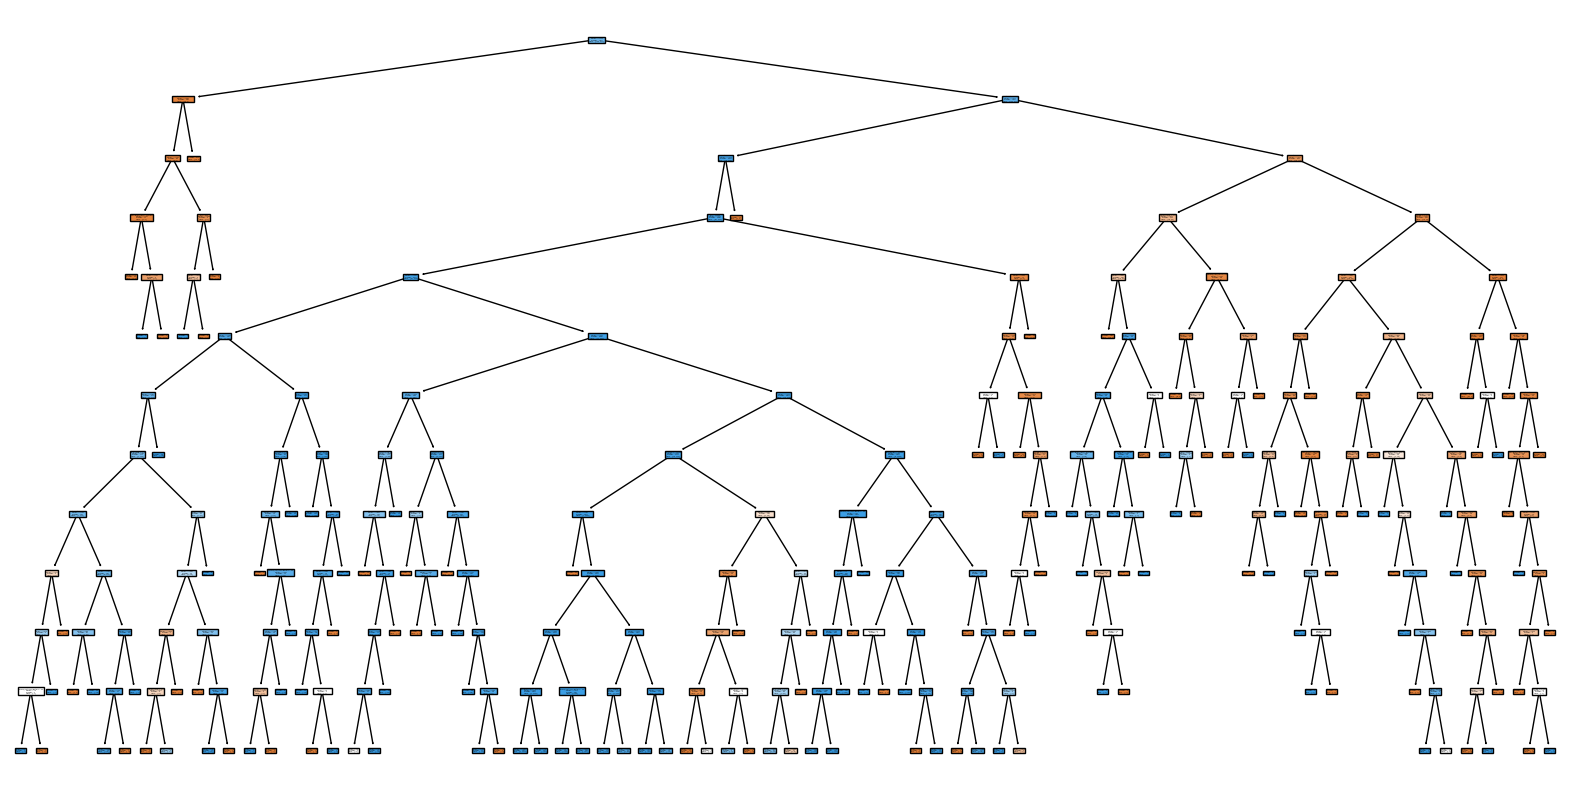

In [46]:
plt.figure(figsize=(20, 10))
plot_tree(tree.best_estimator_, feature_names=x_train.columns, filled=True)
plt.show()


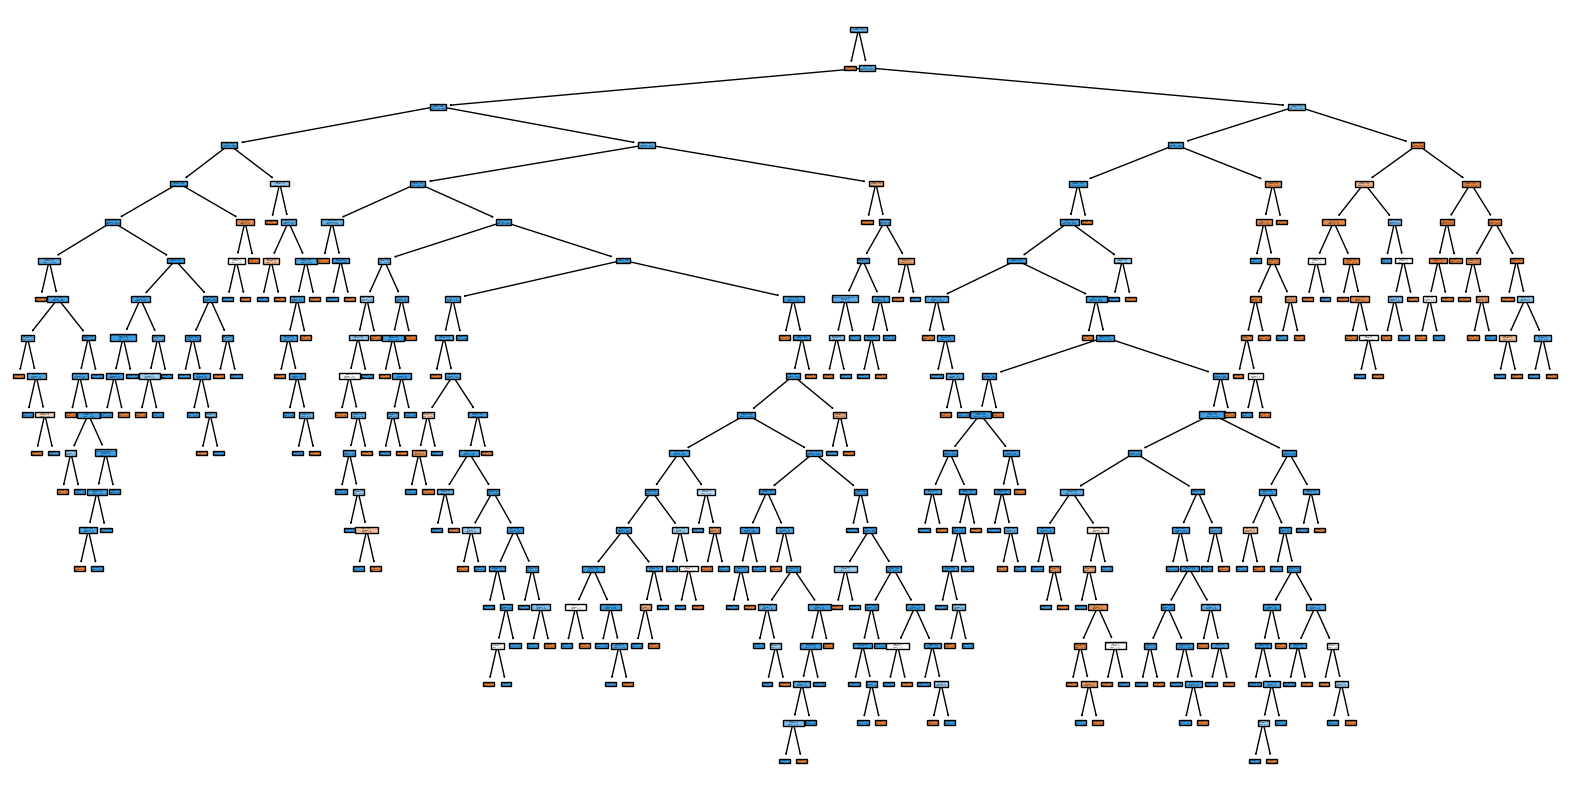

In [47]:
plt.figure(figsize=(20, 10))
plot_tree(forest.best_estimator_.estimators_[
          0], feature_names=x_train.columns, filled=True)
plt.show()


### Questions

1. How did the DT compare to the RF in performance? Why?
   - _Answer_ In my case the DT was much faster to train and had slightly worse (by 2-4%) accuracy than RF. The reason for being faster is that DT is a single model while RF is an ensemble of DTs.
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
   - _Answer_ In my case the max depth of DT was much lower than in RF. The reason for that RF is made up of multiple DTs and each of them has its own depth.
3. What is ensemble learning? What are its pros and cons?
   - _Answer_ Ensemble learning is a machine learning paradigm where multiple models are combined to solve a single problem. The main advantage of ensemble learning is that it can improve the performance of a model by combining the predictions of multiple models. The main disadvantage is that it can be computationally expensive to train.
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
   Which of these categories does RF fall under? 
   - _Answer_ Random forest and Meta-estimators are two types of bagging. Two types of boosting are Adaptive Boosting (AdaBoost) and Gradient Boosting. Random forest is an ensemble learning method that creates several decision trees and outputs class that is the mode of the classes or mean prediction of the individual trees. Meta-estimators are ensemble learning methods that combine several base estimators to improve generalizability and robustness over a single estimator.
   Adaptive Boosting (AdaBoost) is a boosting method that combines several weak learners into a strong learner. The weak learners called decision stumps are decision trees with a single split. The final strong learner is a weighted sum of the weak learners. Gradient Boosting is a boosting method that sequentially adds predictors to an ensemble, each one correcting its predecessor. It works by fitting a new predictor to the residual errors made by the previous predictor.
